In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from wordcloud import WordCloud

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,LSTM,Conv1D,MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score

In [4]:
fake = pd.read_csv("/content/drive/MyDrive/dataset/FakeNewsDetection/Fake.csv")
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [5]:
fake["subject"].value_counts()

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

<Axes: xlabel='subject', ylabel='count'>

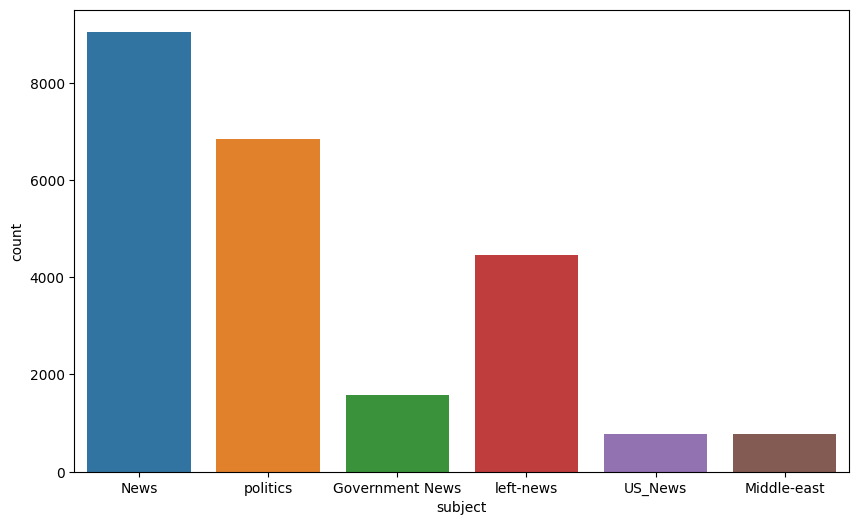

In [6]:
plt.figure(figsize=(10,6))
sns.countplot(x = 'subject', data = fake)

**WordCloud**

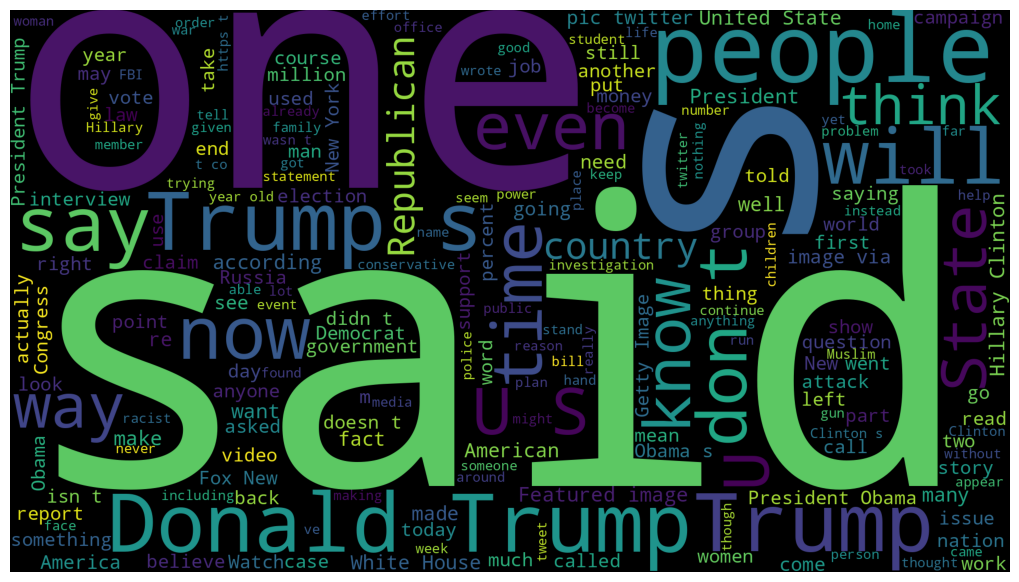

In [7]:
text = ' '.join(fake['text'].tolist())
wordcloud = WordCloud(width = 1920 ,height = 1080).generate(text)
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [41]:
true = pd.read_csv("/content/drive/MyDrive/dataset/FakeNewsDetection/True.csv")
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [9]:
true["subject"].value_counts()

politicsNews    11272
worldnews       10145
Name: subject, dtype: int64

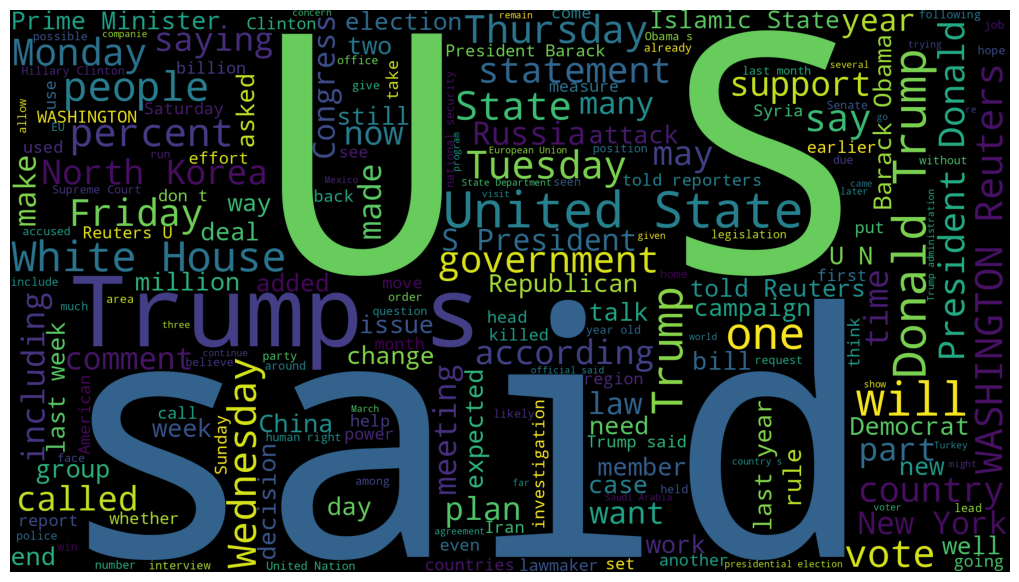

In [10]:
text = ' '.join(true['text'].tolist())
wordcloud = WordCloud(width = 1920 ,height = 1080).generate(text)
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

**Difference in Text**

Real news seems to have source of publication which is not present in fake news set.

Looking at the data :



*   most of the text contains reuters information such as "**WASHINGTON(Reuters)**".
*  Some text are tweets from Twitter
*   Few text do not contain any publications info








#**Cleaning Data**

In [28]:
true.sample(5)

,title,text,subject,date
16331,Alphabet soup as Kazakh leader orders switch t...,ALMATY (Reuters) - Kazakhstan is to change its...,worldnews,"October 26, 2017"
5173,House oversight panel chair: Sessions should '...,"WASHINGTON (Reuters) - Jason Chaffetz, chairma...",politicsNews,"March 2, 2017"
10521,Republican foreign policy veterans rebuke Trum...,WASHINGTON (Reuters) - More than 90 Republican...,politicsNews,"March 3, 2016"
17917,"Tunisian navy rescues 100 migrants, hours afte...",TUNIS (Reuters) - Tunisia s navy rescued almos...,worldnews,"October 10, 2017"
18327,"Prankster, coughing fits mar Theresa May’s spe...","MANCHESTER, England (Reuters) - British Prime ...",worldnews,"October 3, 2017"


In [42]:
unknown_publishers = []
for index,row in enumerate(true.text.values):
  try:
    record = row.split("-",maxsplit=1)
    record[1]
    assert(len(record[0])<120)

  except:
    unknown_publishers.append(index)


In [43]:
true.iloc[8970]

title      Graphic: Supreme Court roundup
text                                     
subject                      politicsNews
date                       June 16, 2016 
Name: 8970, dtype: object

In [44]:
true = true.drop(8970,axis=0)

In [45]:
len(unknown_publishers)

222

In [46]:
true.iloc[unknown_publishers].text

7        The following statements were posted to the ve...
8        The following statements were posted to the ve...
12       The following statements were posted to the ve...
13       The following statements were posted to the ve...
14        (In Dec. 25 story, in second paragraph, corre...
                               ...                        
20136    LIMA (Reuters) - The government of Peru s Pres...
20501    BEIJING (Reuters) - Chinese importers of forei...
20668    (Reuters) - Hurricane Irma, one of the most po...
21247    LONDON (Reuters) - Princes William and Harry p...
21340    LONDON (Reuters) - Britain will pay  not a pen...
Name: text, Length: 222, dtype: object

In [48]:
publisher = []
temp_text = []
for index,row in enumerate(true.text.values):
  if index in unknown_publishers:
    temp_text.append(row)
    publisher.append("Unknown")

  else:
    record = row.split("-",maxsplit=1)
    publisher.append(record[0].strip())
    temp_text.append(record[1].strip())

In [49]:
true['publisher'] = publisher
true['text'] = temp_text

In [50]:
true.head()

,title,text,subject,date,publisher
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...,politicsNews,"December 29, 2017",WASHINGTON (Reuters)
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...,politicsNews,"December 30, 2017",WASHINGTON (Reuters)
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters)


In [51]:
true.shape

(21416, 5)

In [54]:
empty_fake_index = [index for index,text in enumerate(fake.text.tolist()) if str(text).strip()=='']

In [55]:
fake.iloc[empty_fake_index]

,title,text,subject,date
10923,TAKE OUR POLL: Who Do You Think President Trum...,,politics,"May 10, 2017"
11041,Joe Scarborough BERATES Mika Brzezinski Over “...,,politics,"Apr 26, 2017"
11190,WATCH TUCKER CARLSON Scorch Sanctuary City May...,,politics,"Apr 6, 2017"
11225,MAYOR OF SANCTUARY CITY: Trump Trying To Make ...,,politics,"Apr 2, 2017"
11236,SHOCKER: Public School Turns Computer Lab Into...,,politics,"Apr 1, 2017"
...,...,...,...,...
21816,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,,left-news,"Apr 27, 2015"
21826,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,"Apr 25, 2015"
21827,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,"Apr 25, 2015"
21857,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,"Apr 14, 2015"


In [58]:
true['text'] = (true['title'] + ' ' + true['text']).apply(lambda x: str(x).lower())

In [59]:
fake['text'] = (fake['title'] + ' ' + fake['text']).apply(lambda x: str(x).lower())

# Preprocessing Text

In [60]:
true['class'] = 1
fake['class'] = 0

In [62]:
true = true[['text','class']]
fake = fake[['text','class']]

In [67]:
data = pd.concat([true,fake],axis=0)

In [70]:
data.sample(5)

,text,class
15795,u.n. refugee commissioner says australia must ...,1
17060,iraq oil ministry warns oil companies against ...,1
475,ice may soon be able to destroy records of im...,0
11093,clinton 'happy' to join extra debate if other ...,1
2378,report: sean spicer forces staffers to surren...,0


In [74]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [71]:
import re
import nltk
nltk.download('wordnet')
from nltk.util import pr
from nltk.stem import WordNetLemmatizer
import string
from nltk import sent_tokenize,word_tokenize
nltk.download("stopwords")
from nltk.corpus import stopwords
stopword = set(stopwords.words("english"))
from bs4 import BeautifulSoup

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [72]:
lemmatizer = WordNetLemmatizer()
def clean(text):
  text = str(text).lower()
  text = re.sub('\[.*?\]','',text)
  text = re.sub('https?://\S+|www\.\S+','',text)
  text = re.sub('<.*?>+','',text)
  text = re.sub('[%s]'% re.escape(string.punctuation),'',text)
  text = re.sub('\n','',text)
  text = re.sub('\w*\d\w*','',text)
  text = [word for word in text.split(' ') if word not in stopword]
  text = " ".join(text)
  text = [lemmatizer.lemmatize(word) for word in text.split(' ')]
  text = " ".join(text)
  return text

In [73]:
def preprocess(q):
  q = str(q).lower().strip()

   # Replace certain special characters with their string equivalents
  q = q.replace('%', ' percent')
  q = q.replace('$', ' dollar ')
  q = q.replace('₹', ' rupee ')
  q = q.replace('€', ' euro ')
  q = q.replace('@', ' at ')

    # The pattern '[math]' appears around 900 times in the whole dataset.
  q = q.replace('[math]', '')

    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
  q = q.replace(',000,000,000 ', 'billion')
  q = q.replace(',000,000 ', 'million')
  q = q.replace(',000 ', 'thousand')
  q = re.sub(r'([0-9]+)000000000', r'\1billion', q)
  q = re.sub(r'([0-9]+)000000', r'\1million', q)
  q = re.sub(r'([0-9]+)000', r'\1thousand', q)

    # Decontracting words
    # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
    # https://stackoverflow.com/a/19794953
  contractions = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
     "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
     "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }
  q_decontracted = []

  for word in q.split():
      if word in contractions:
          word = contractions[word]

      q_decontracted.append(word)

  q = ' '.join(q_decontracted)
  q = q.replace("'ve", " have")
  q = q.replace("n't", " not")
  q = q.replace("'re", " are")
  q = q.replace("'ll", " will")

    # Removing HTML tags
  q = BeautifulSoup(q)
  q = q.get_text()

  return q

In [75]:
data['text'] = data['text'].apply(clean)
data['text'] = data['text'].apply(preprocess)

In [76]:
import gensim

In [77]:
y = data['class'].values

In [78]:
x = [d.split() for d in data['text'].tolist()]

In [86]:
DIM = 100
w2v_model = gensim.models.Word2Vec(sentences = x,vector_size = DIM,window = 10,min_count = 1)

In [89]:
len(w2v_model.wv)

217284

In [90]:
w2v_model.wv.most_similar('pollution')

[('fuel', 0.7721140384674072),
 ('carbon', 0.744755744934082),
 ('methane', 0.7430881261825562),
 ('consumption', 0.7404789328575134),
 ('emission', 0.7370283007621765),
 ('electricity', 0.7352292537689209),
 ('pollutant', 0.7331005930900574),
 ('drilling', 0.7204388380050659),
 ('emit', 0.7145311832427979),
 ('dioxide', 0.7085146307945251)]

In [91]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x)

In [92]:
x = tokenizer.texts_to_sequences(x)

In [93]:
tokenizer.word_index

{'trump': 1,
 'said': 2,
 'u': 3,
 'state': 4,
 'would': 5,
 'president': 6,
 'people': 7,
 'republican': 8,
 'one': 9,
 'year': 10,
 'new': 11,
 'say': 12,
 'house': 13,
 'also': 14,
 'clinton': 15,
 'obama': 16,
 'government': 17,
 'donald': 18,
 'time': 19,
 'white': 20,
 'election': 21,
 'could': 22,
 'country': 23,
 'american': 24,
 'told': 25,
 'united': 26,
 'like': 27,
 'campaign': 28,
 'party': 29,
 'official': 30,
 'news': 31,
 'right': 32,
 'last': 33,
 'two': 34,
 'group': 35,
 'hillary': 36,
 'first': 37,
 'make': 38,
 'former': 39,
 'law': 40,
 'get': 41,
 'vote': 42,
 'even': 43,
 'court': 44,
 'day': 45,
 'medium': 46,
 'want': 47,
 'security': 48,
 'democrat': 49,
 'may': 50,
 'week': 51,
 'many': 52,
 'national': 53,
 'bill': 54,
 'video': 55,
 'leader': 56,
 'police': 57,
 'woman': 58,
 'political': 59,
 'million': 60,
 'made': 61,
 'image': 62,
 'back': 63,
 'take': 64,
 'support': 65,
 'know': 66,
 'russia': 67,
 'going': 68,
 'trump’s': 69,
 'tax': 70,
 'president

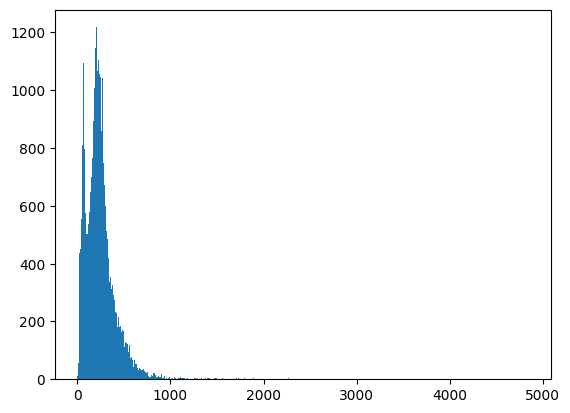

In [94]:
plt.hist([len(X) for X in x],bins = 700)
plt.show()

In [95]:
nos = np.array([len(X) for X in x])
len(nos[nos>1000])

296

In [96]:
maxlen = 1000
x = pad_sequences(x,maxlen = maxlen)

In [97]:
len(x[744])

1000

In [99]:
vocab_size = len(tokenizer.word_index) + 1
vocab = tokenizer.word_index

In [100]:
def get_weight_matrix(model):
  weight_matrix = np.zeros((vocab_size,DIM))
  for word,i in vocab.items():
    weight_matrix[i] = model.wv[word]

  return weight_matrix

In [102]:
embedding_vectors = get_weight_matrix(w2v_model)
embedding_vectors.shape

(217285, 100)

In [104]:
model = Sequential()
model.add(Embedding(vocab_size,output_dim=DIM,weights = [embedding_vectors],input_length = maxlen,trainable = True))
model.add(LSTM(units = 128))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])

In [105]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1000, 100)         21728500  
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 21,845,877
Trainable params: 21,845,877
Non-trainable params: 0
_________________________________________________________________


In [106]:
x_train,x_test,y_train,y_test = train_test_split(x,y)

In [107]:
model.fit(x_train,y_train,validation_split=0.3,epochs=6)

Epoch 1/6
737/737 [==============================] - 197s 257ms/step - loss: 0.1357 - acc: 0.9501 - val_loss: 0.0887 - val_acc: 0.9676
Epoch 2/6
737/737 [==============================] - 109s 148ms/step - loss: 0.0522 - acc: 0.9825 - val_loss: 0.0391 - val_acc: 0.9867
Epoch 3/6
737/737 [==============================] - 84s 114ms/step - loss: 0.0219 - acc: 0.9931 - val_loss: 0.0305 - val_acc: 0.9905
Epoch 4/6
737/737 [==============================] - 92s 125ms/step - loss: 0.0088 - acc: 0.9974 - val_loss: 0.0282 - val_acc: 0.9910
Epoch 5/6
737/737 [==============================] - 78s 106ms/step - loss: 0.0040 - acc: 0.9992 - val_loss: 0.0237 - val_acc: 0.9944
Epoch 6/6
737/737 [==============================] - 50s 68ms/step - loss: 0.0021 - acc: 0.9994 - val_loss: 0.0335 - val_acc: 0.9910


In [108]:
y_pred = (model.predict(x_test) >=0.5).astype(int)

351/351 [==============================] - 5s 14ms/step


In [109]:
accuracy_score(y_test,y_pred)

0.9893095768374165

In [110]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      5952
           1       0.98      1.00      0.99      5273

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225



In [111]:
x = ['this is a news']
x = tokenizer.texts_to_sequences(x)
x = pad_sequences(x,maxlen = maxlen)

In [112]:
(model.predict(x) >=0.5).astype(int)

1/1 [==============================] - 0s 52ms/step


array([[0]])

In [113]:
x = ['A highly mutated Covid variant called BA.2.86 has now been detected in Switzerland and South Africa in addition to Israel, Denmark, the US and the UK, according to a leading World Health Organisation official.The Omicron offshoot carries more than 35 mutations in key portions of the virus compared with XBB.1.5, the dominant variant through most of 2023 - a number roughly on par with the Omicron variant that caused record infections compared to its predecessor.It was first spotted in Denmark on July 24 after the virus infecting a patient at risk of becoming severely ill was sequenced. It has since been detected in other symptomatic patients, in routine airport screening, and in wastewater samples in a handful of countries.A dozen scientists around the world said while it was important to monitor BA.2.86, it was unlikely to cause a devastating wave of severe disease and death given immune defenses built up worldwide from vaccination and prior infection.']
x = tokenizer.texts_to_sequences(x)
x = pad_sequences(x,maxlen = maxlen)
(model.predict(x) >=0.5).astype(int)

1/1 [==============================] - 0s 124ms/step


array([[1]])

Models train accuracy - 0.9994

Models validation accuracy - 0.9910

Models test accuracy - 0.9893